---------
# Université de Limoges
## CRYPTIS MASTER 2 - XLIM  - Examen de Travaux Pratiques 
### Implementation et Cartes à puces -- Side Channel Analysis
-------

Date: vendredi 9 février 2024

DUREE : 2H
----


# CE NOTEBOOK EST UN EXAMPLE DE SOLUTION 


----
# SUJET 

## Matériel à utiliser pour cet examen de TP

Le notebook prêt à être utilisé se trouve ici: https://github.com/BeneoLix/SideCA-TP-CWLite

* fichier = TP_SCA_EXAM_XLIM_2024.ipynb

Et les traces à utiliser ici: https://github.com/BeneoLix/SideSCA-Traces-Public

* fichier = anonymous_exec_traces.ets


### 0. Veuillez cloner ou télécharger ces deux fichier et les mettre dans votre environnement Jupyter Lab (ou Jupyter notebook) pour les executer 
... de la même manière que ce que nous avons fait pendant les 3 TPs.


### 1. Etape 1: faite une analyse simple (de type SPA) des traces afin de reconnaitre l'algorithme attaqué ... 
* Expliquez à quoi on le reconnait
* Expliquez quelles opérations on peut reconnaitre dans la trace et à quel endroit

### 2. Etape 2: attaquez les traces en DPA et en CPA pour retrouver la clef si possible

* Retrouvez vous la clef en DPA et en CPA?

* Si oui combien de traces faut il au moins avec la DPA pour retrouver la clef complète à 10 traces près ?

* Si oui combien de traces faut il au moins avec la CPA pour retrouver la clef complète à 10 traces près ?

* Comparez l'efficacité de ces deux attaques: la DPA vs la CPA 


### Pour l'éxécutions des taches requises en 1. et 2. __l'étudiant est libre de réaliser ces analyses dans l'ordre qu'il souhaite (!!!) __ mais doit présenter une analyse construite et logique.


------

### Votre travail sera réalisé dans ce notebook:
- Utilisez les cellules en mode markdown pour mettre votre texte, vos explications
- Utiliser les cellules de code pour faire vos tests
- Vous pouvez sauver le notebook avec les images
- Je rejouerai le notebook de toue facon lors de la correction

### Bon examen de TP !

-----------
* __NOM:__ Jean 
* __PRENOM:__ DUPONT
--------

In [1]:
import estraces
import scared

In [2]:
import numpy as np

In [3]:
vhex = np.vectorize(hex)

In [4]:
ths = estraces.read_ths_from_ets_file("../SideCA-Traces/anonymous_exec_traces.ets") 
print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file ../SideCA-Traces/anonymous_exec_traces.ets with 1000 traces.
ciphertext.......: uint8
plaintext........: uint8



In [5]:
import matplotlib.pyplot as plt

In [6]:
plt.rcParams['figure.figsize']=(16,4)

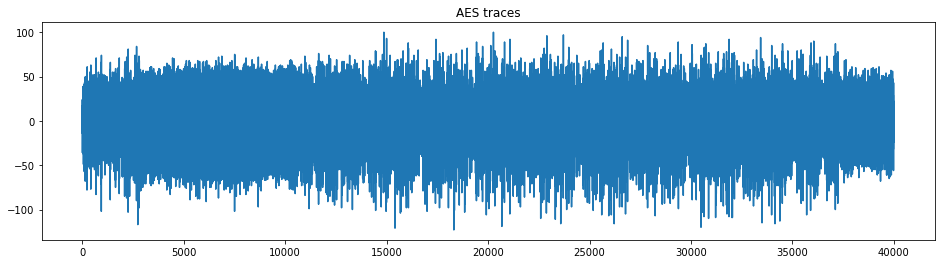

In [7]:
plt.plot(ths.samples[0:1].T)
plt.title('AES traces')
plt.show()

In [8]:
ths.metadata_tags

['ciphertext', 'plaintext']

---------
## Simple Observation
#### Appilcation un post processing simple comme la moyenne glissante pour observe les patterns dans la trace.

In [9]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
window_pts = 10
trace_mov_mean = moving_average(ths[0].samples, window_pts)

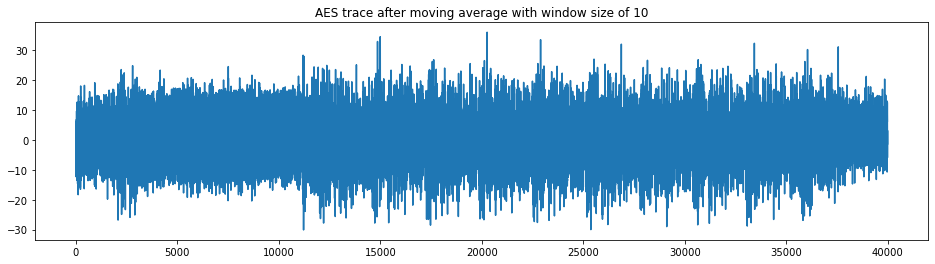

In [11]:
plt.rcParams['figure.figsize']=(16,4)
plt.plot(trace_mov_mean)
plt.title('AES trace after moving average with window size of '+str(window_pts))
plt.show()

Les résultats obtenus n'étant pas significatifs nous allons désormais tester la moyenne et l'écart type sur un ensemble de plusieurs traces.

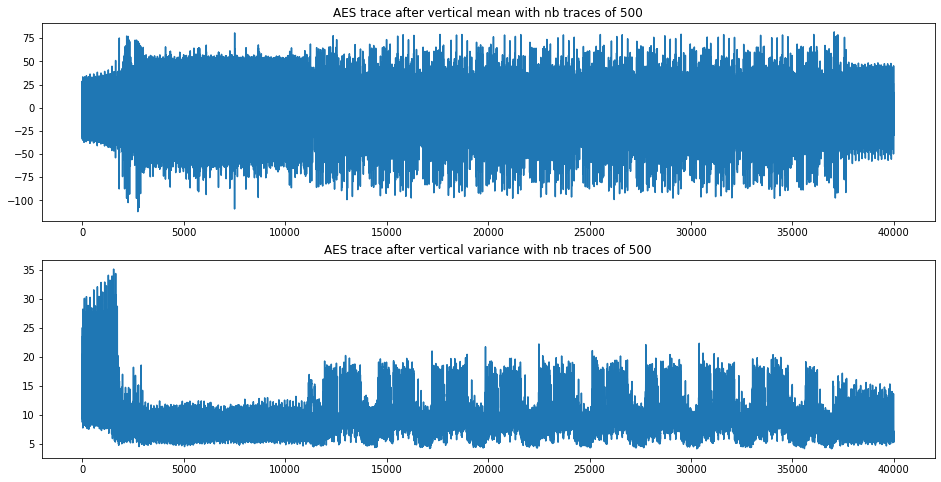

In [12]:
plt.rcParams['figure.figsize']=(16,8)
traces_number = 500
trace_mean = np.mean(ths[0:traces_number].samples, axis = 0)
trace_std = np.std(ths[0:traces_number].samples, axis = 0)
plt.subplot(2,1,1) 
plt.title('AES trace after vertical mean with nb traces of '+str(traces_number))
plt.plot(trace_mean)
plt.subplot(2,1,2) 
plt.title('AES trace after vertical variance with nb traces of '+str(traces_number))
plt.plot(trace_std)
plt.show()

### Identifions et surlignons les rondes de l'AES

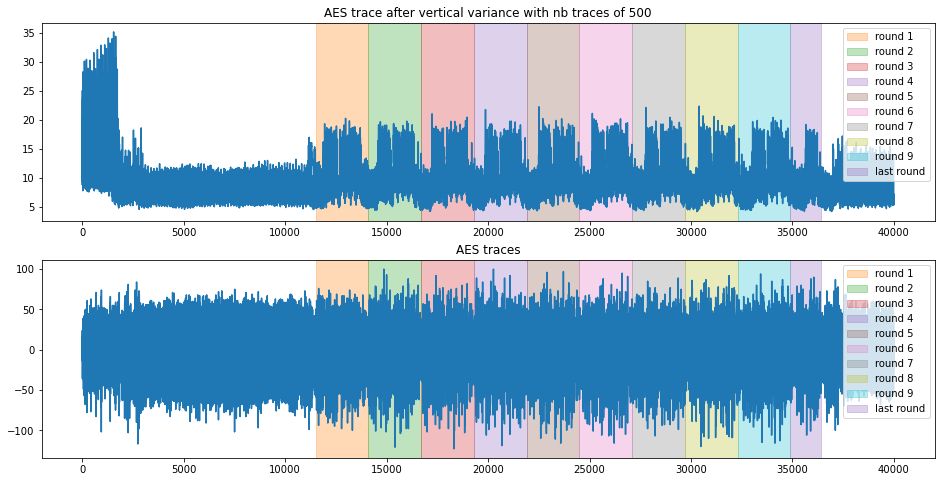

In [13]:
plt.rcParams['figure.figsize']=(16,8)

beg_first_round = 11_500
round_length = 2600
borders = np.arange(beg_first_round, (beg_first_round+10*round_length), round_length)
last_round_length = 1500

plt.subplot(2,1,1) 
for i in range(1,10):    plt.axvspan(borders[i-1], borders[i], color='C'+str(i), alpha=0.3, label='round '+str(i))
plt.axvspan(borders[9], borders[9]+last_round_length, color='C14', alpha=0.3, label='last round')
plt.title('AES trace after vertical variance with nb traces of '+str(traces_number))
plt.plot(trace_std)
plt.legend(loc='upper right')

plt.subplot(2,1,2) 
for i in range(1,10):    plt.axvspan(borders[i-1], borders[i], color='C'+str(i), alpha=0.3, label='round '+str(i))
plt.axvspan(borders[9], borders[9]+last_round_length, color='C14', alpha=0.3, label='last round')
plt.plot(ths.samples[0:1].T)
plt.title('AES traces')
plt.legend(loc='upper right')

plt.show()

### Analyse:
#### On peut aisément identifier les 9 premières rondes de l'AES ainsi que la dernière ronde plus courte car cettte dernière ne contient pas l'opération MixColumn.


### Zoomons à l'intérieur des rondes de l'AES

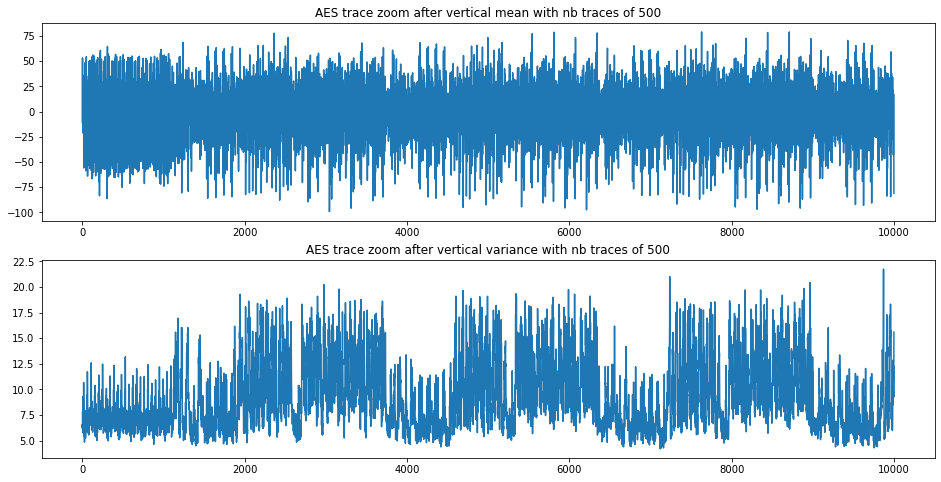

In [14]:
plt.rcParams['figure.figsize']=(16,8)
segment = range(10_000,20_000)
plt.subplot(2,1,1) 
plt.title('AES trace zoom after vertical mean with nb traces of '+str(traces_number))
plt.plot(trace_mean[segment])
plt.subplot(2,1,2) 
plt.title('AES trace zoom after vertical variance with nb traces of '+str(traces_number))
plt.plot(trace_std[segment])
plt.show()

Peut on identifier les opérations de chaque ronde?

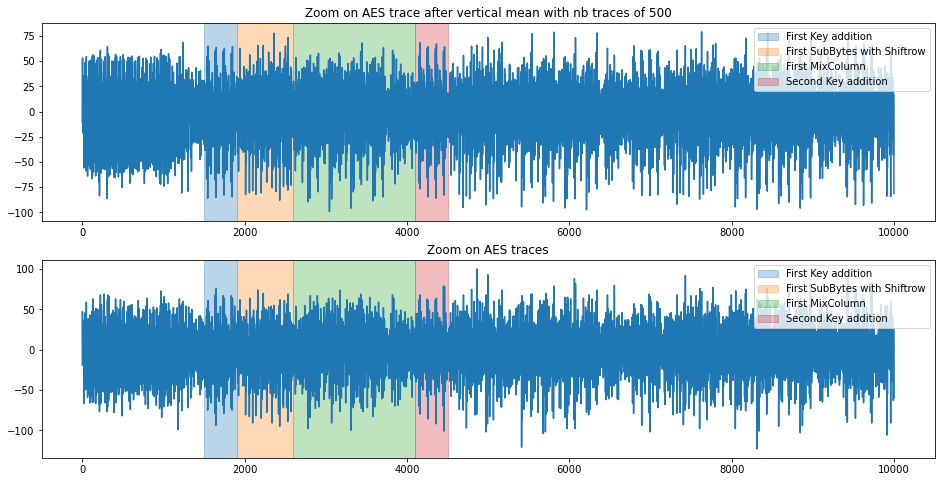

In [15]:
plt.rcParams['figure.figsize']=(16,8)

beg_first_round = 11_500-segment[0]

plt.subplot(2,1,1) 
plt.axvspan(beg_first_round, beg_first_round+400, color='C0', alpha=0.3, label='First Key addition')
plt.axvspan(beg_first_round+400, beg_first_round+1100, color='C1', alpha=0.3, label='First SubBytes with Shiftrow')
plt.axvspan(beg_first_round+1100, beg_first_round+2600, color='C2', alpha=0.3, label='First MixColumn')
plt.axvspan(beg_first_round+2600, beg_first_round+3000, color='C3', alpha=0.3, label='Second Key addition')
plt.title('Zoom on AES trace after vertical mean with nb traces of '+str(traces_number))
plt.plot(trace_mean[segment])
plt.legend(loc='upper right')

plt.subplot(2,1,2) 
plt.axvspan(beg_first_round, beg_first_round+400, color='C0', alpha=0.3, label='First Key addition')
plt.axvspan(beg_first_round+400, beg_first_round+1100, color='C1', alpha=0.3, label='First SubBytes with Shiftrow')
plt.axvspan(beg_first_round+1100, beg_first_round+2600, color='C2', alpha=0.3, label='First MixColumn')
plt.axvspan(beg_first_round+2600, beg_first_round+3000, color='C3', alpha=0.3, label='Second Key addition')
plt.plot(ths.samples[0:1].T[segment])
plt.title('Zoom on AES traces')
plt.legend(loc='upper right')

plt.show()

### Analyse:
#### On peut dans chaque ronde d'AES identifier la partie qui correspond à l'addition de la clef, a l'opération SubBytes(incluant ShiftRow) et le MixColumn.


------
<img src='images/DoIt.png' style='width: 100px'>

# Peut on retrouver la clef ?

## La CPA étant généralement plus performante que la DPA commencons par la CPA pour voir si on peut retrouver la clef de l'AES.

In [16]:
# Create a container for your ths
container = scared.Container(ths)

On va attaquer en première ronde de l'AES, en sortie l'opération non linéaire SubBytes.
* Nous allons choisir la CPA comme distinguisher, 
* nous considérons que le modèle de fuite est linéaire en le poids de Hamming des données manipulées,
* le score de l'attaque sera le maximum de la corrélation en valeur absolue pour chaque guess our chaque byte de clef,
* nous allons utiliser la convergence pour voir l'évolution de l'attaque toutes les 100 traces sur un total de 1000 traces.

In [17]:
attack_cpa_first_SBout = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//10    
    )

In [18]:
attack_cpa_first_SBout.run(container)

Les scores obtenus sont stoqués dans `attack_cpa_first_sbout.scores`

In [19]:
attack_cpa_first_SBout.scores.shape

(256, 16)

On a un tableau de 256 x 16 éléments qui correspond au nombre de guess possibles(256) pour chaque byte des 16 bytes de clef de l'AES.
En prenant pour chacun des 16 bytes de clef l'indice du guess qui a le score maximum nous espérons retrouver la clef.

In [20]:
found_key = attack_cpa_first_SBout.scores.argmax(0).squeeze()

In [21]:
vhex = np.vectorize(hex)
print("the first subkey round found is: ", vhex(np.array(found_key)))

the first subkey round found is:  ['0xb8' '0x95' '0xf' '0x65' '0x1b' '0xb8' '0x82' '0xc3' '0x62' '0x1f'
 '0x2b' '0x40' '0x5c' '0xf1' '0x18' '0x7']


----
------
<img src='images/DoIt.png' style='width: 100px'>

## Vérifions que la clef retrouvée est la bonne


In [22]:
computed_cipher = scared.aes.encrypt(plaintext = ths[0].plaintext, key = np.array(found_key, dtype=np.uint8))
print(vhex(computed_cipher))
print(vhex(ths[0].ciphertext))

['0x11' '0x0' '0xd1' '0x32' '0xc0' '0xfd' '0xf7' '0x29' '0x3b' '0x9c'
 '0x39' '0x68' '0xf8' '0x28' '0xa5' '0xa0']
['0x11' '0x0' '0xd1' '0x32' '0xc0' '0xfd' '0xf7' '0x29' '0x3b' '0x9c'
 '0x39' '0x68' '0xf8' '0x28' '0xa5' '0xa0']


In [23]:
computed_cipher - ths[0].ciphertext

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [24]:
correct_key = found_key

### La clef retrouvée en CPA avec 1000 traces est la bonne.


----
------
<img src='images/DoIt.png' style='width: 100px'>


## Quel est le nombre de traces minimum (à 10 près) nécéssaire pour retrouver la clef directement avec la CPA.

### Affichons les résultats et observons les traces de convergence pour obtenir une première approximation du nombre de traces nécéssaires au succès de la CPA.

In [25]:
attack_cpa_first_SBout.convergence_traces.shape

(256, 16, 10)

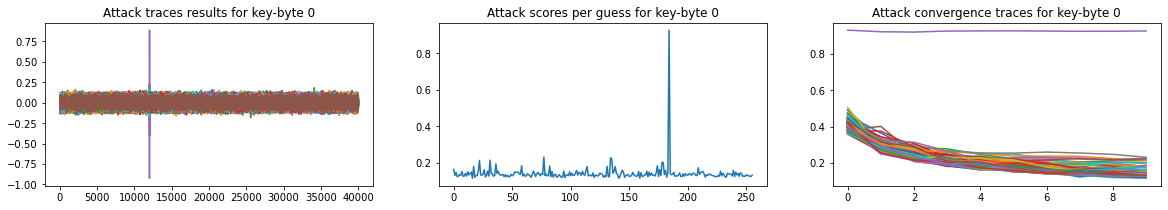

In [26]:
key_byte = 0
plt.rcParams['figure.figsize']=(20,3)
plt.subplot(1,3,1)
plt.title('Attack traces results for key-byte '+str(key_byte))
plt.plot(attack_cpa_first_SBout.results.T[:,key_byte,:])
plt.subplot(1,3,2)
plt.title('Attack scores per guess for key-byte '+str(key_byte))
plt.plot(attack_cpa_first_SBout.scores[:,key_byte])
plt.subplot(1,3,3)
plt.title('Attack convergence traces for key-byte '+str(key_byte))
plt.plot(attack_cpa_first_SBout.convergence_traces.T[:,key_byte, :])
plt.show()

### Pour être sur de notre observation affichons le vrai byte de clef en rouge et les 255 autres candidats en gris

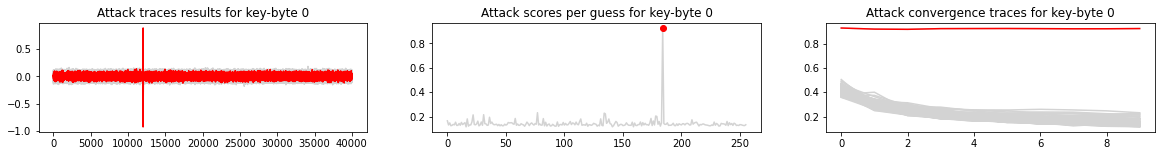

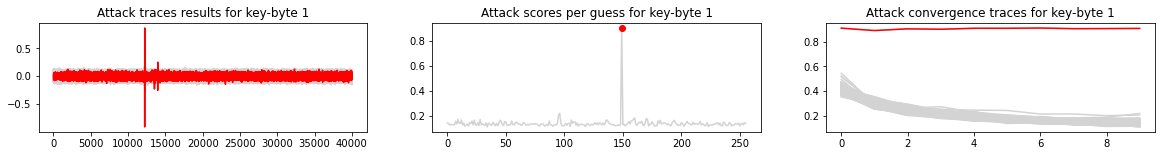

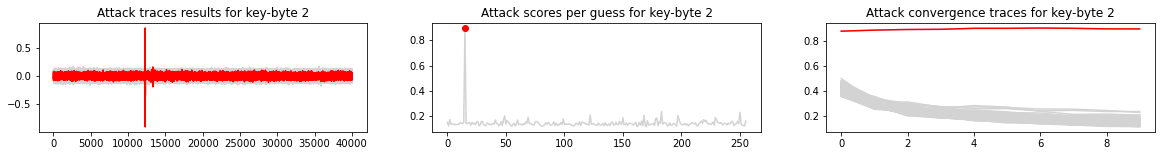

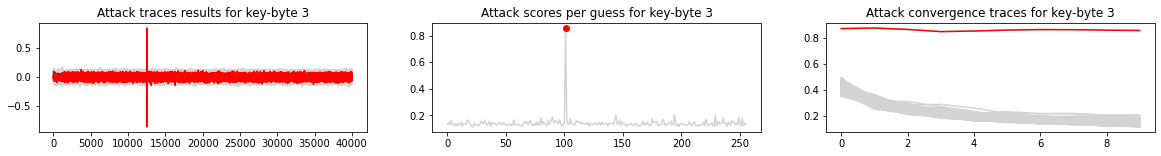

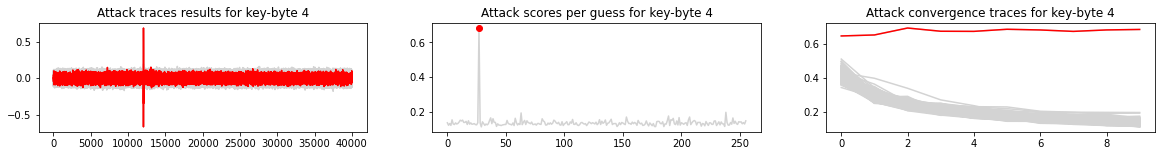

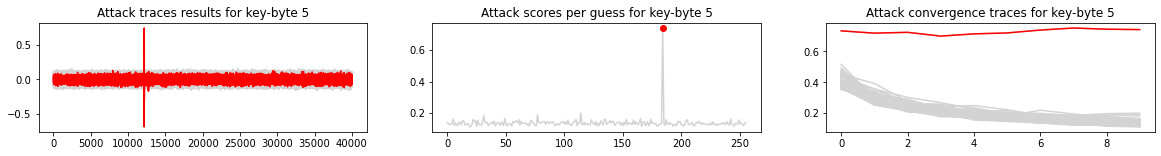

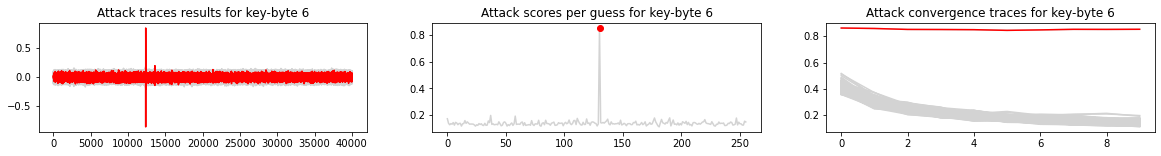

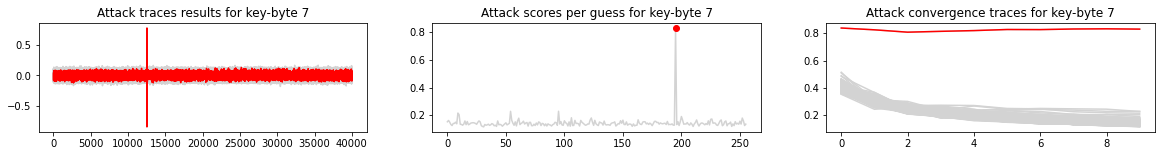

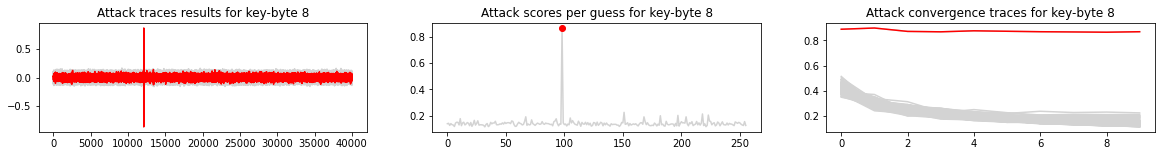

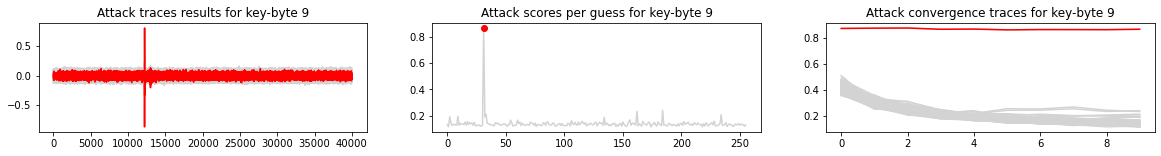

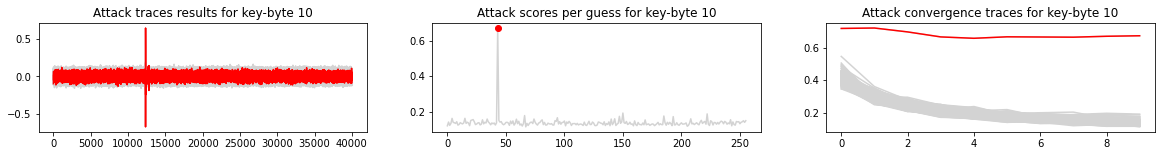

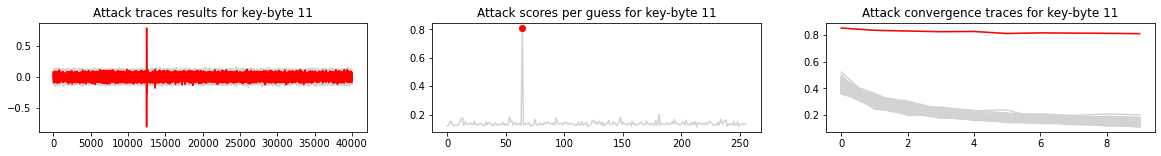

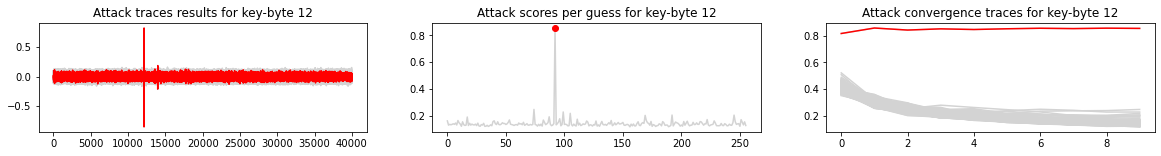

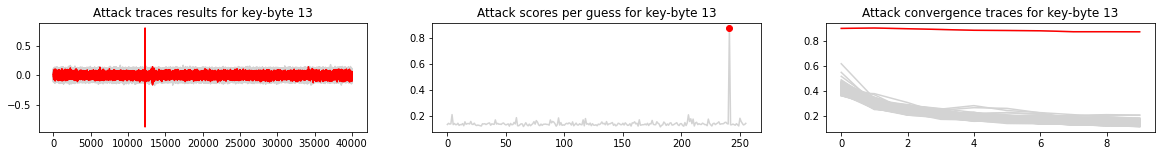

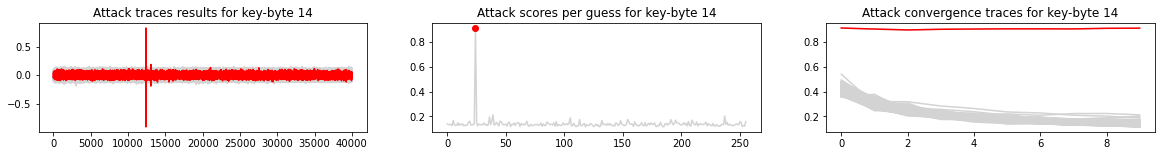

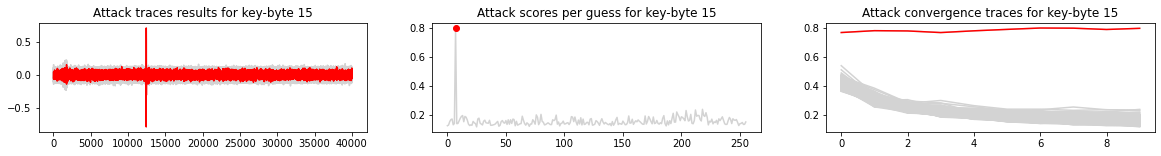

In [27]:
for key_byte in range(16):
    plt.rcParams['figure.figsize']=(20,2)
    
    plt.subplot(1,3,1)
    plt.title('Attack traces results for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_first_SBout.results[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_first_SBout.results[correct_key[key_byte],key_byte,:], color='red')

    plt.subplot(1,3,2)
    plt.title('Attack scores per guess for key-byte '+str(key_byte))
    plt.plot(attack_cpa_first_SBout.scores[:,key_byte], color='Lightgrey')
    plt.plot(correct_key[key_byte], attack_cpa_first_SBout.scores[correct_key[key_byte], key_byte], "o", color = 'red')

    
    plt.subplot(1,3,3)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_first_SBout.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_first_SBout.convergence_traces[correct_key[key_byte],key_byte,:], color='red')

    plt.show()

### Nous observons que pour tous les bytes de clef il semble que 100 traces soient plus que suffisants.

Relancons l'attaque avec moins de traces et une granularité de 10 pour la convergence .

In [28]:
# Create a container for your ths
nb_traces_used = 100
container = scared.Container(ths[:nb_traces_used])

In [29]:
attack_cpa_first_SBout = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths[:nb_traces_used])//20 
    )

In [30]:
attack_cpa_first_SBout.run(container)

/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: divide by zero encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/scared/discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


In [31]:
found_key = attack_cpa_first_SBout.scores.argmax(0).squeeze()

In [32]:
vhex = np.vectorize(hex)
print("the first subkey round found is: ", vhex(np.array(found_key)))

the first subkey round found is:  ['0xb8' '0x95' '0xf' '0x65' '0x1b' '0xb8' '0x82' '0xc3' '0x62' '0x1f'
 '0x2b' '0x40' '0x5c' '0xf1' '0x18' '0x7']


In [33]:
found_key - correct_key

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### La clef retrouvée est toujours la bonne avec 100 traces.

### Pour être sur de notre observation affichons le vrai byte de clef en rouge et les 255 autres candidats en gris
### Limitons nous aux traces de convergence et affichons le nombre exact de traces en abscisse.

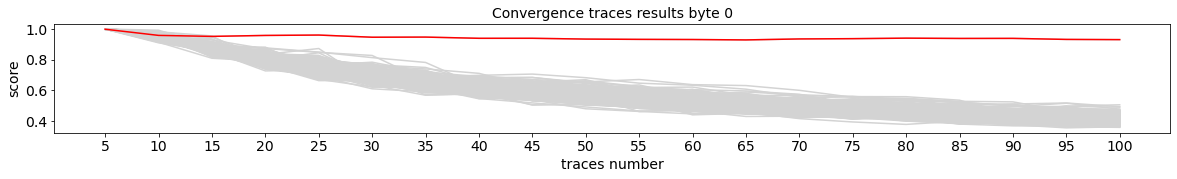

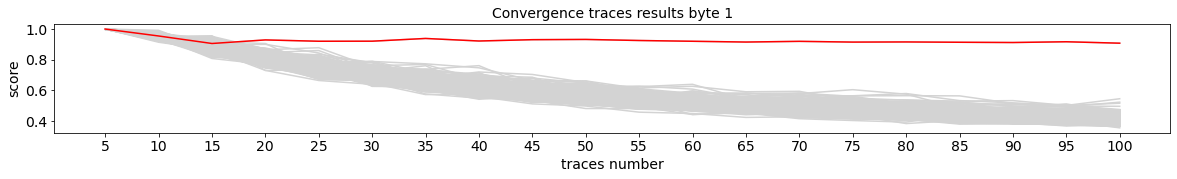

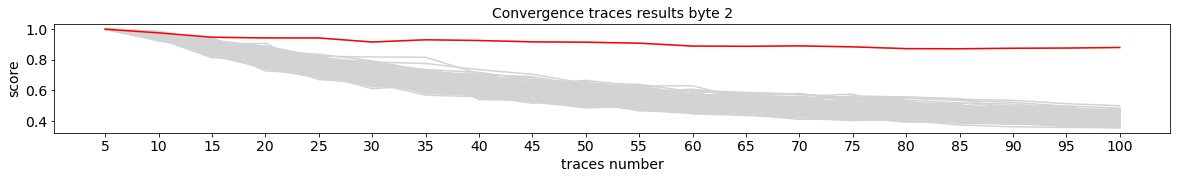

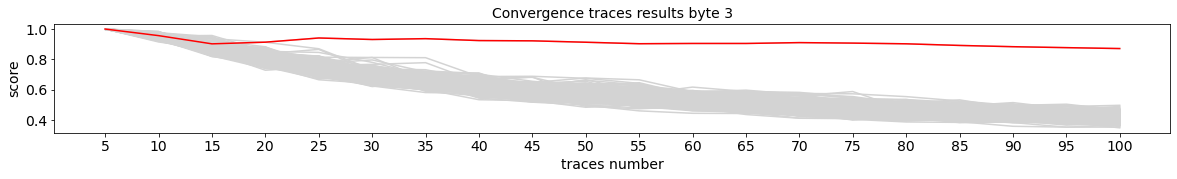

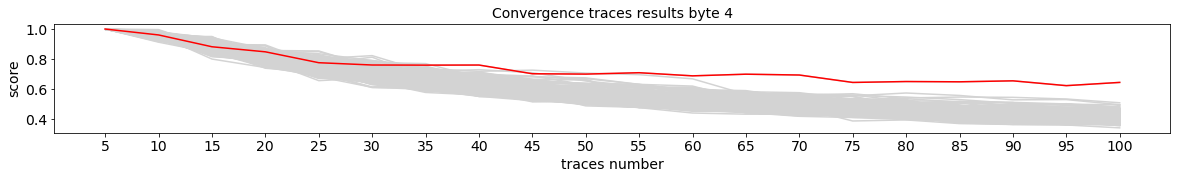

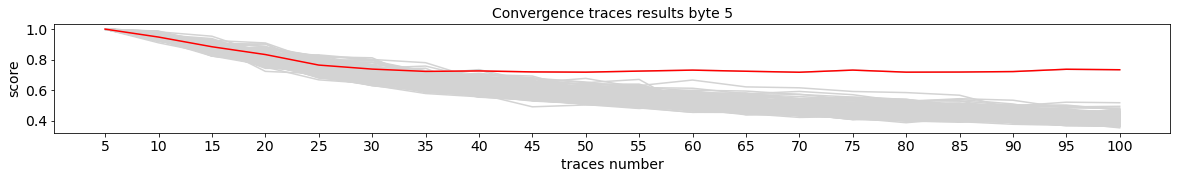

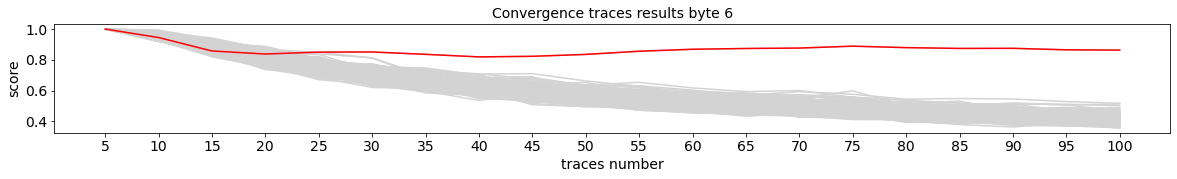

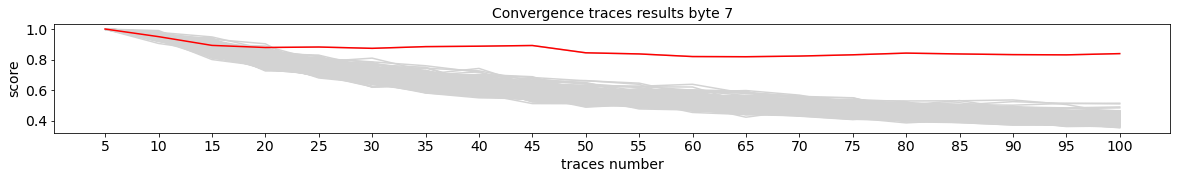

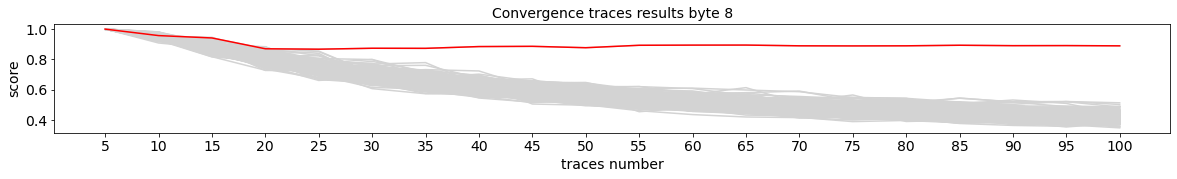

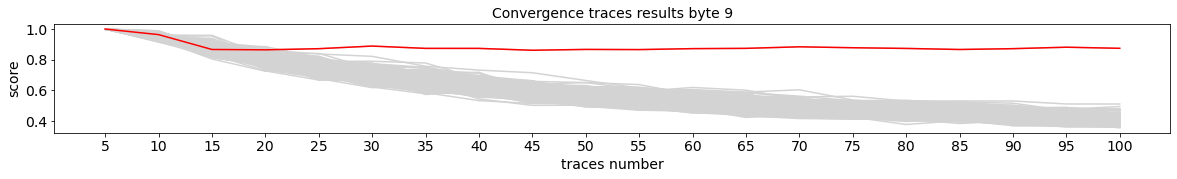

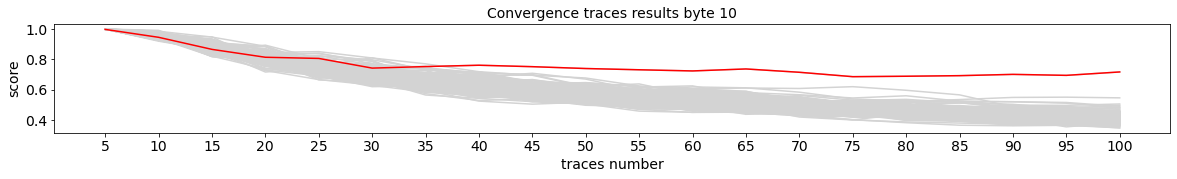

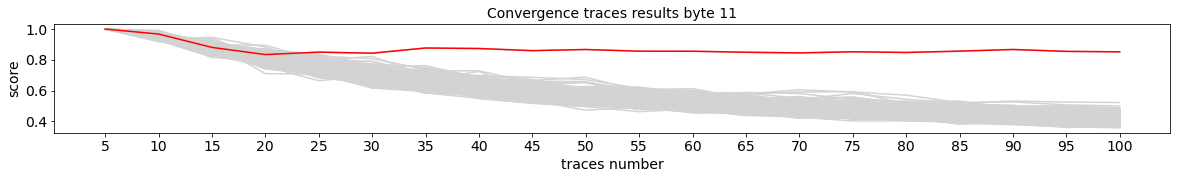

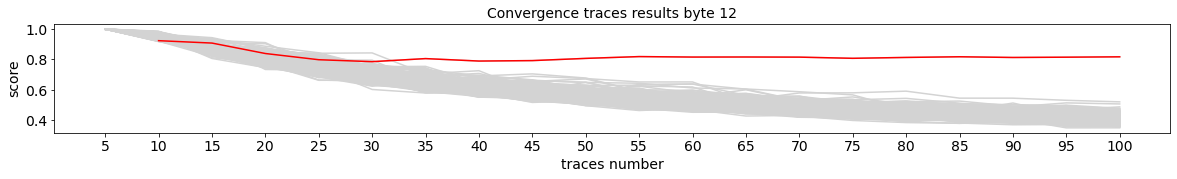

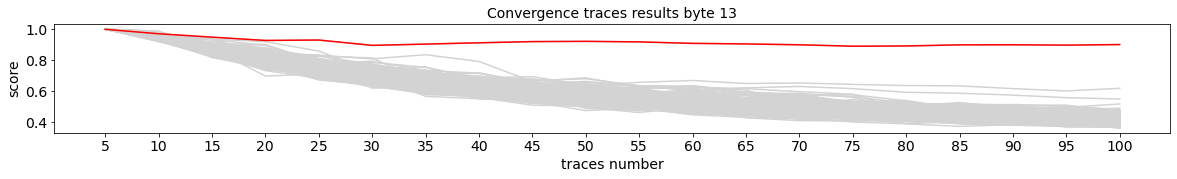

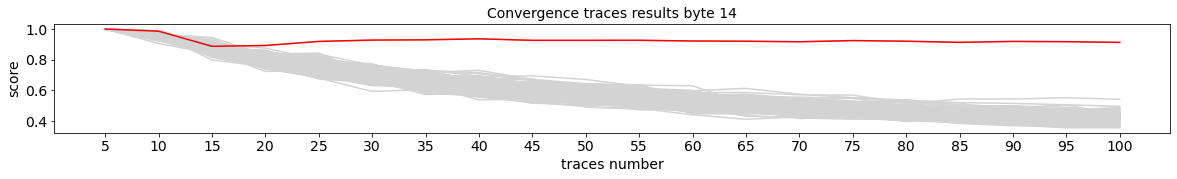

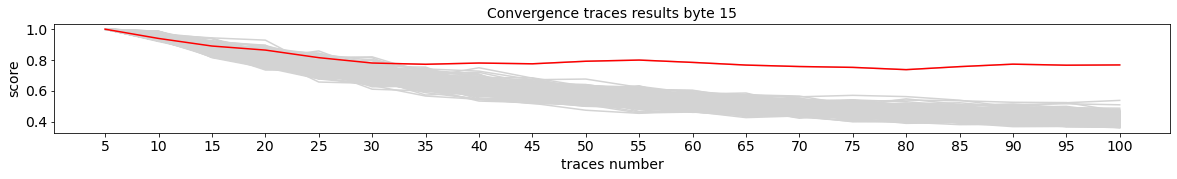

In [34]:
for key_byte in range(16):
    
    figure_axes_text_size = 14    
    plt.rcParams['figure.figsize']=(20,2)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    CONV_POINTS =  attack_cpa_first_SBout.convergence_traces.shape[2]
    
    # Set axes and legend
    plt.xlabel('traces number', size = figure_axes_text_size)
    plt.ylabel('score', size = figure_axes_text_size)
    plt.xticks(np.arange(0,CONV_POINTS, 1),np.arange(1,CONV_POINTS+1, 1)*(attack_cpa_first_SBout.convergence_step), size = figure_axes_text_size)
    plt.title('Convergence traces results byte '+str(key_byte), size = figure_axes_text_size)
    plt.yticks(size = figure_axes_text_size)
    
    for guess in range(256):
        plt.plot(attack_cpa_first_SBout.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_first_SBout.convergence_traces[correct_key[key_byte],key_byte,:], color='red')

    plt.show()

## Conclusion

### Le byte 4 requiert 60 traces sur les traces de convergence et semble être le pire résultat des 16 bytes de clef.
### Donc a 10 courbes près on peut conclure qu'il faut 60 traces d'AES pour retrouver la clef.

### Il suffit de relancer l'attaque avec 50 traces: manque le byte 4 et 60 traces (full recovery) pour en avoir la confirmation

------
<img src='images/DoIt.png' style='width: 100px'>

# Voyons ce que donne la DPA maintenant que nous connaissons la vraie clef pour vérifier

In [35]:
container = scared.Container(ths)

In [36]:
attack_dpa_first_SBout = scared.DPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.Monobit(0),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//10    
    )

In [37]:
attack_dpa_first_SBout.run(container)

In [38]:
found_key = attack_dpa_first_SBout.scores.argmax(0).squeeze()

In [39]:
vhex = np.vectorize(hex)
print("the first subkey round found is: ", vhex(np.array(found_key)))

the first subkey round found is:  ['0xb8' '0x95' '0xf' '0x65' '0x1b' '0xb8' '0x82' '0xc3' '0x62' '0x1f'
 '0x2b' '0x40' '0x5c' '0xf1' '0x18' '0x6b']


In [40]:
found_key - correct_key

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 100])

## --> Il semblerait donc que en s'y prenant de la sorte, la DPA, à elle seule, ne permet pas de retrouver toute la clef avec 1000 traces, il manquerait un byte.

### Pour être sur de notre observation affichons le vrai byte de clef en rouge et les 255 autres candidats en gris

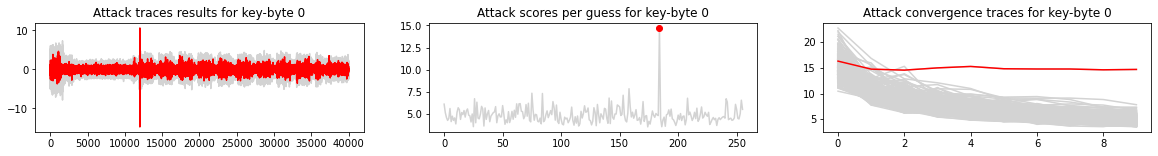

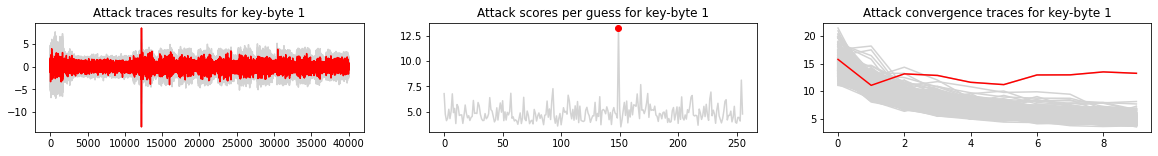

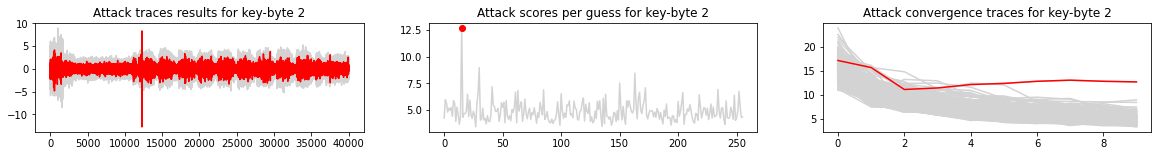

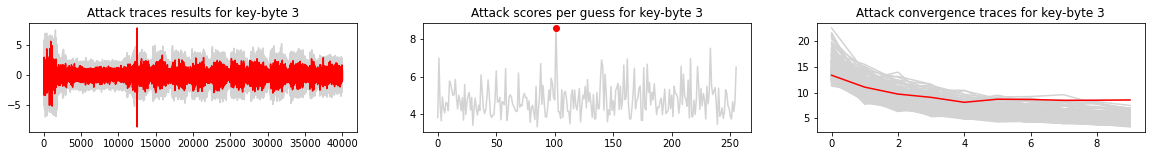

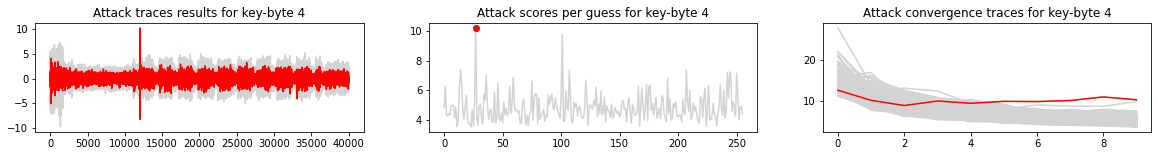

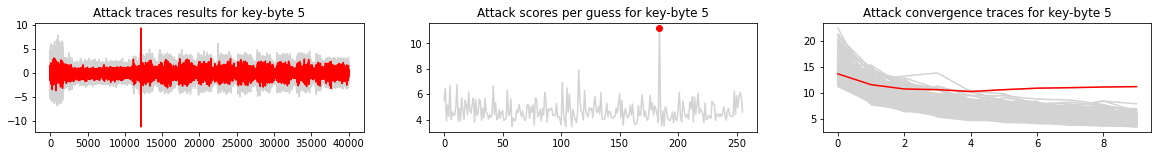

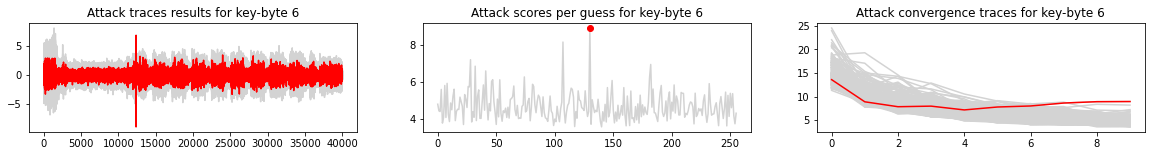

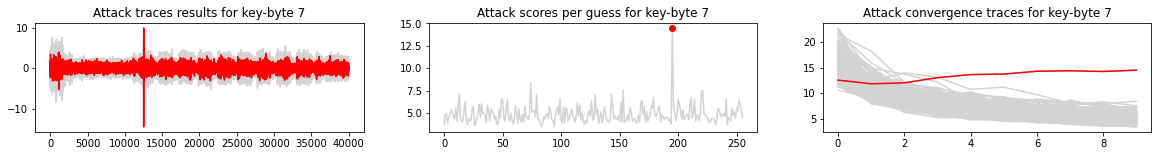

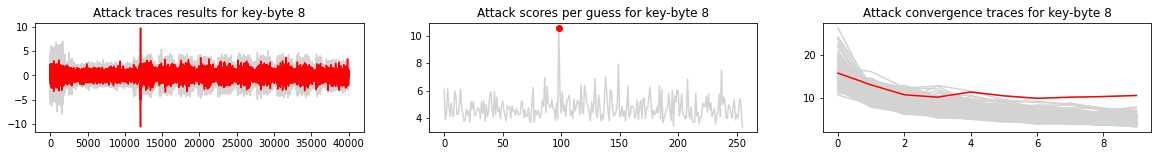

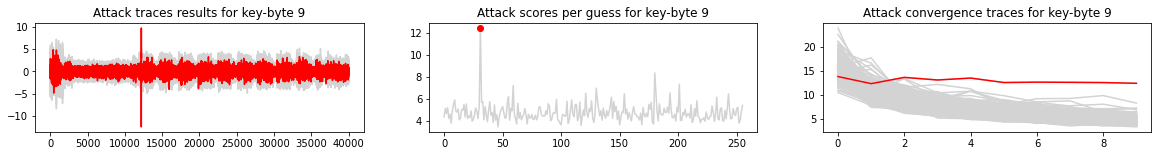

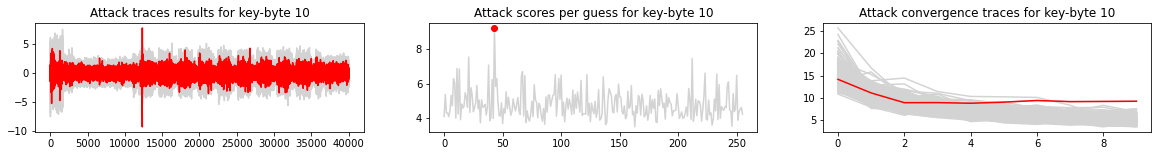

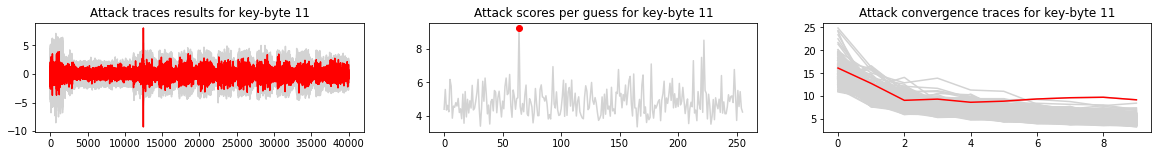

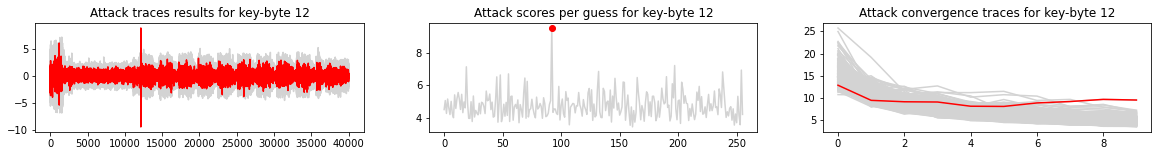

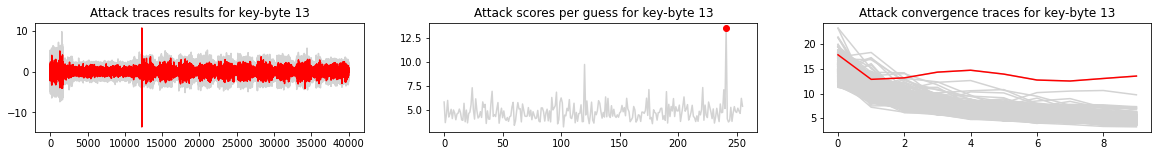

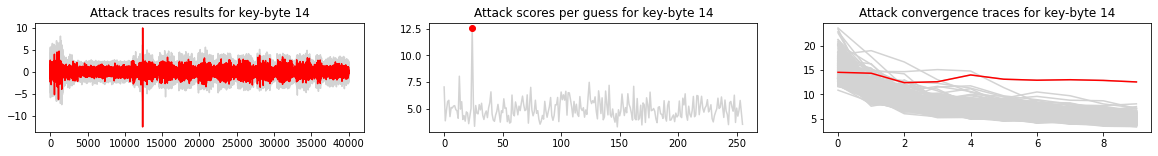

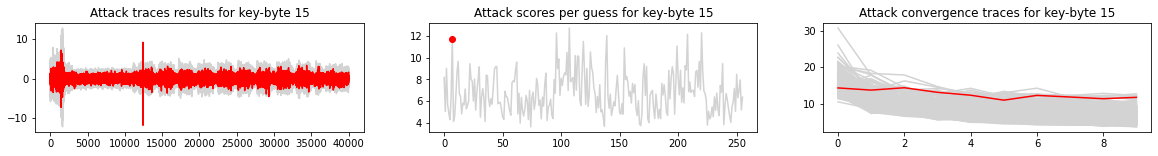

In [41]:
for key_byte in range(16):
    plt.rcParams['figure.figsize']=(20,2)
    
    plt.subplot(1,3,1)
    plt.title('Attack traces results for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_dpa_first_SBout.results[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_dpa_first_SBout.results[correct_key[key_byte],key_byte,:], color='red')

    plt.subplot(1,3,2)
    plt.title('Attack scores per guess for key-byte '+str(key_byte))
    plt.plot(attack_dpa_first_SBout.scores[:,key_byte], color='Lightgrey')
    plt.plot(correct_key[key_byte], attack_dpa_first_SBout.scores[correct_key[key_byte], key_byte], "o", color = 'red')

    
    plt.subplot(1,3,3)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_dpa_first_SBout.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_dpa_first_SBout.convergence_traces[correct_key[key_byte],key_byte,:], color='red')

    plt.show()

### Analyse
* Le byte 15 n'est pas retrouvé en DPA
* Les bytes 4, 6 et 11 sortent en premier mais pas nettement.

### __Mais nous ne pouvons pas pour autant conclure que l'attaque DPA ne permet pas de retrouver les bytes de clef avec 1000 traces.__

On observe que des ghost peaks sont présents au début de la courbe ce qui fausse les résultats, hors ces peaks ne sont pas dans la zone de la ronde 1 probablement?

Souvenons nous, et cela aurait pu être utilisé dès le début aussi, que nous attaquons en première ronde de l'AES, hors nous avons su repéré la première ronde dans la trace de l'AES collectée.

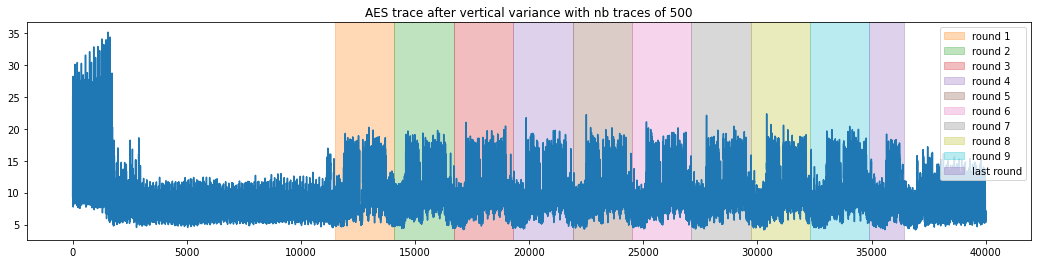

In [42]:
plt.rcParams['figure.figsize']=(18,4)

beg_first_round = 11_500
round_length = 2600
borders = np.arange(beg_first_round, (beg_first_round+10*round_length), round_length)
last_round_length = 1500

for i in range(1,10):    plt.axvspan(borders[i-1], borders[i], color='C'+str(i), alpha=0.3, label='round '+str(i))
plt.axvspan(borders[9], borders[9]+last_round_length, color='C14', alpha=0.3, label='last round')
plt.title('AES trace after vertical variance with nb traces of '+str(traces_number))
plt.plot(trace_std)
plt.legend(loc='upper right')

plt.show()

Nous pouvons donc concentrer l'attaque DPA (et la CPA) uniquement sur la zone dans la trace qui correspond à la première ronde, soit à l'intervalle de points [11_500, 14_100], nous pourrions même réduire encore plus car nous avons également repéré précisément dans la trace la zone correspondant à SubBytes dans la première ronde.

### Relançons l'attaque DPA dans cette fenêtre uniquement

In [43]:
container = scared.Container(ths, frame = range(11_500,14_000))

In [44]:
attack_dpa_first_SBout = scared.DPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.FirstSubBytes(),
        model=scared.Monobit(0),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//20    
    )

In [45]:
attack_dpa_first_SBout.run(container)

In [46]:
found_key = attack_dpa_first_SBout.scores.argmax(0).squeeze()

In [47]:
vhex = np.vectorize(hex)
print("the first subkey round found is: ", vhex(np.array(found_key)))

the first subkey round found is:  ['0xb8' '0x95' '0xf' '0x65' '0x1b' '0xb8' '0x82' '0xc3' '0x62' '0x1f'
 '0x2b' '0x40' '0x5c' '0xf1' '0x18' '0x7']


In [48]:
found_key - correct_key

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Cette fois ci, la DPA retrouve toute la clef, nous voyons bien l'interêt de repérer dans un premier temps en analyse la zone qui nous importe avant de réaliser l'attaque.

### Observons à nouveau les résultats et concluons sur le nombre de traces nécéssaires au succès de l'attaque DPA

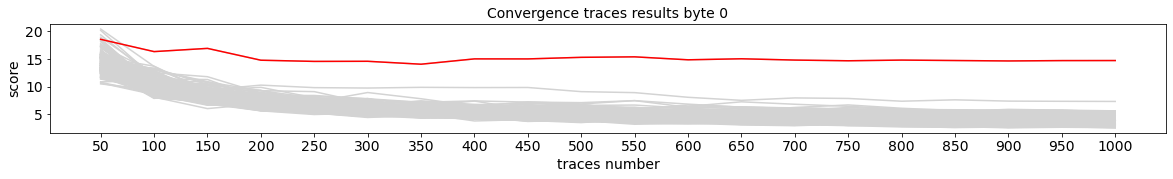

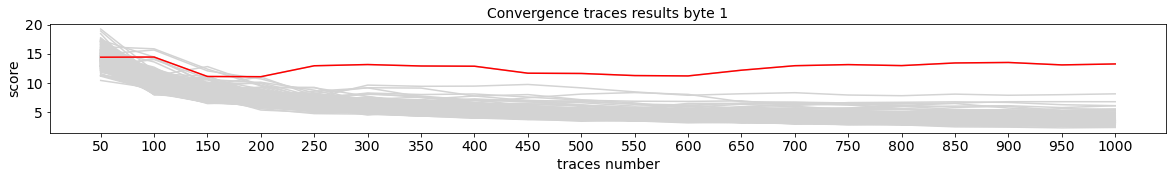

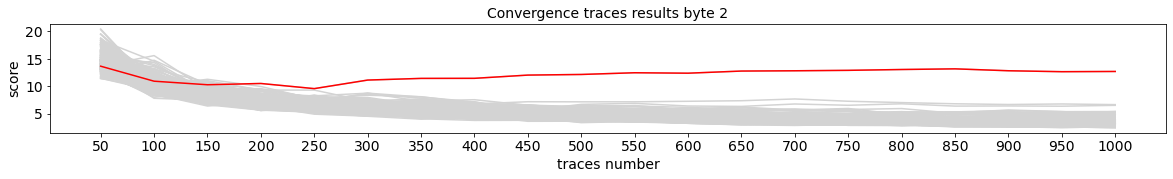

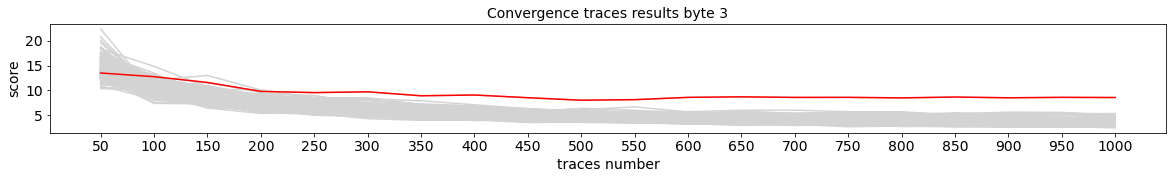

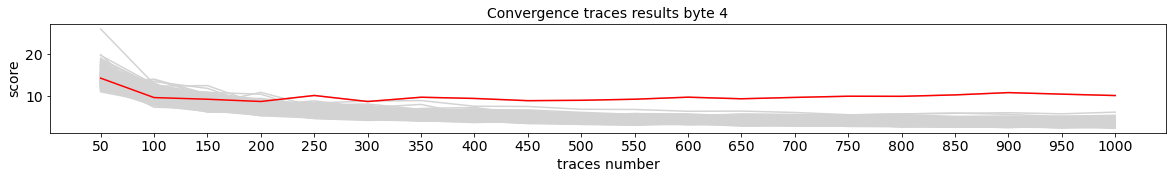

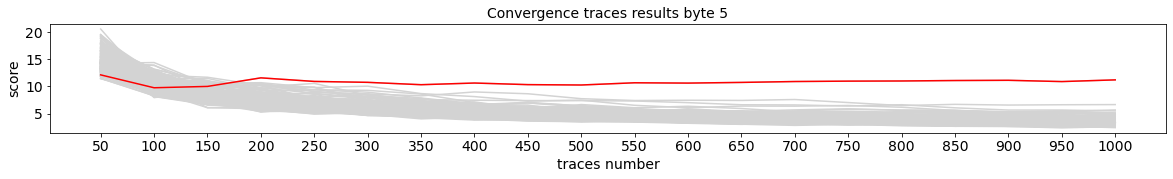

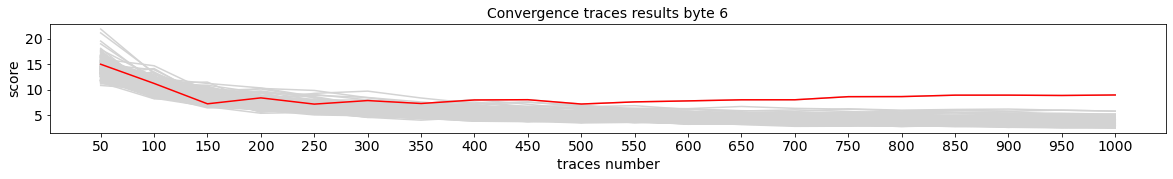

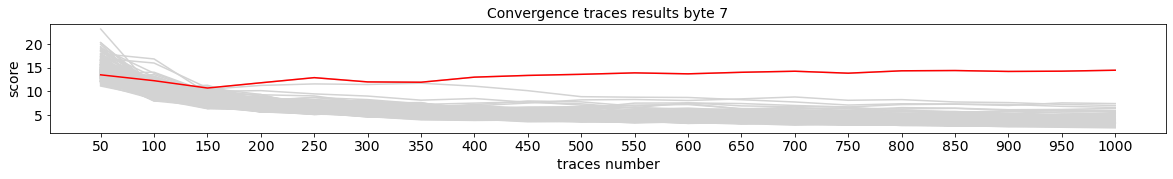

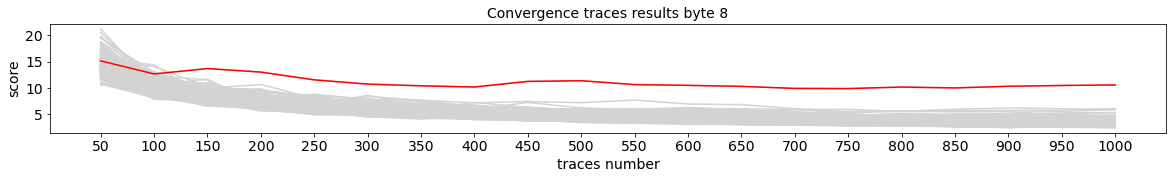

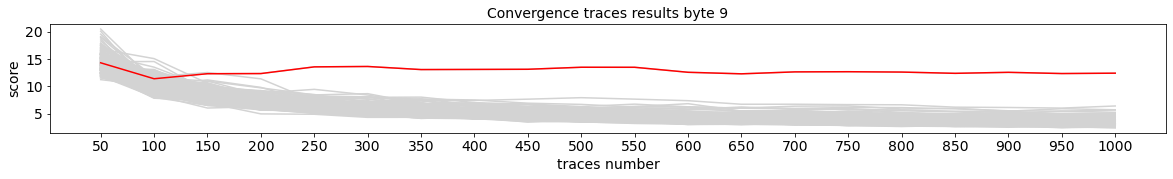

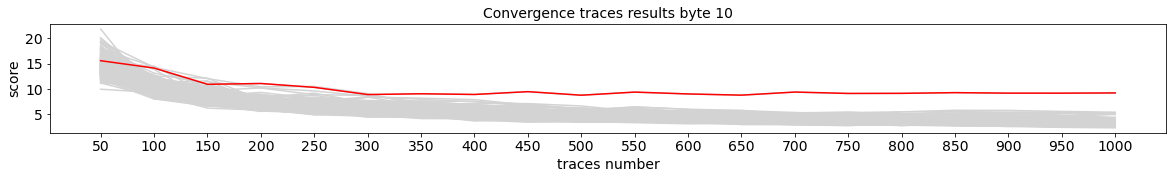

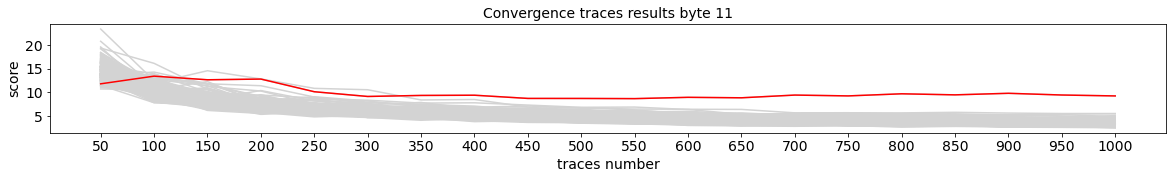

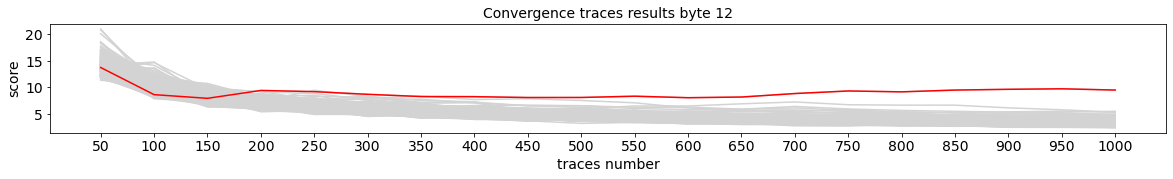

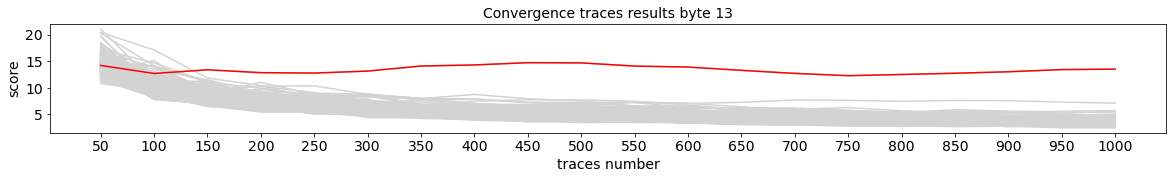

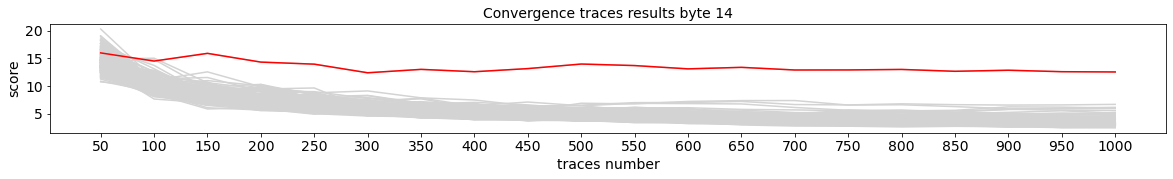

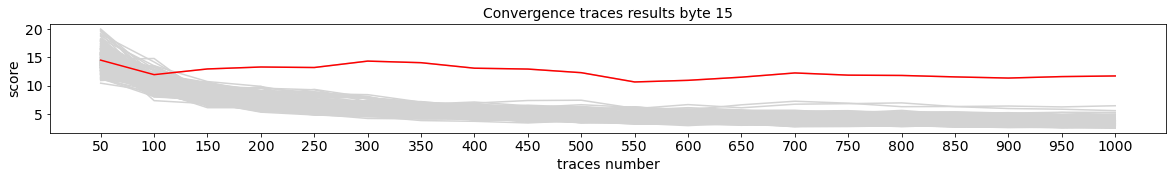

In [49]:
for key_byte in range(16):
    
    plt.rcParams['figure.figsize']=(20,2)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    CONV_POINTS =  attack_dpa_first_SBout.convergence_traces.shape[2]
    
    # Set axes and legend
    plt.xlabel('traces number', size = figure_axes_text_size)
    plt.ylabel('score', size = figure_axes_text_size)
    plt.xticks(np.arange(0,CONV_POINTS, 1),np.arange(1,CONV_POINTS+1, 1)*(attack_dpa_first_SBout.convergence_step), size = figure_axes_text_size)
    plt.title('Convergence traces results byte '+str(key_byte), size = figure_axes_text_size)
    plt.yticks(size = figure_axes_text_size)
    
    for guess in range(256):
        plt.plot(attack_dpa_first_SBout.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_dpa_first_SBout.convergence_traces[correct_key[key_byte],key_byte,:], color='red')

    plt.show()

### On peut donc retrouver la clef en DPA avec 550 traces environ.

----
------
<img src='images/DoIt.png' style='width: 100px'>

# CONCLUSION DU TP


## On observe ainsi que la CPA permet de retrouver la clef complète avec 60 traces d'AES quand la DPA requiert 550 traces et que l'on focalise l'attaque sur la zone temporelle (de la trace) correspondant à la première ronde.



------
## Optionel: réaliser l'attaque par la fin de l'algorithme par le chiffré

In [57]:
container = scared.Container(ths)

In [58]:
attack_cpa_last_SBin = scared.CPAAttack(
        selection_function=scared.aes.selection_functions.encrypt.LastSubBytes(),
        model=scared.HammingWeight(),
        discriminant=scared.maxabs,
        convergence_step=len(ths)//10    
    )

In [59]:
attack_cpa_last_SBin.run(container)

In [60]:
found_key = attack_cpa_last_SBin.scores.argmax(0).squeeze()

In [61]:
vhex = np.vectorize(hex)
print("the last subkey round found is: ", vhex(found_key))

the last subkey round found is:  ['0xcd' '0x36' '0x3b' '0x25' '0xcd' '0x62' '0x69' '0x21' '0xa9' '0x50'
 '0x13' '0xf' '0xde' '0x5e' '0xdc' '0x1']


### Ici nous attaquons la dernière ronde de l'AES, donc la clef attendue est la dernière sous clef du key schedule de l'AES 128 et non pas la clef maitre de l'AES.

Calculons donc cette dernière sous clef pour la comparer avec la clef attendue.

In [62]:
last_round_subkey = scared.aes.key_schedule(np.array(correct_key, dtype=np.uint8))[-1]
print("the correct last subkey round is: ", vhex(last_round_subkey))

the correct last subkey round is:  ['0xcd' '0x36' '0x3b' '0x25' '0xcd' '0x62' '0x69' '0x21' '0xa9' '0x50'
 '0x13' '0xf' '0xde' '0x5e' '0xdc' '0x1']


In [63]:
found_key - last_round_subkey

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Nous pouvons retrouver la dernière sous clef de l'AES en attaquant par la fin et donc retrouver la clef maitre de l'AES en inversant le key schedule de l"AES.

In [ ]:
for key_byte in range(16):
    plt.rcParams['figure.figsize']=(20,2)
    
    plt.subplot(1,3,1)
    plt.title('Attack traces results for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_last_SBin.results[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_last_SBin.results[last_round_subkey[key_byte],key_byte,:], color='red')

    plt.subplot(1,3,2)
    plt.title('Attack scores per guess for key-byte '+str(key_byte))
    plt.plot(attack_cpa_last_SBin.scores[:,key_byte], color='Lightgrey')
    plt.plot(last_round_subkey[key_byte], attack_cpa_last_SBin.scores[last_round_subkey[key_byte], key_byte], "o", color = 'red')

    
    plt.subplot(1,3,3)
    plt.title('Attack convergence traces for key-byte '+str(key_byte))
    for guess in range(256):
        plt.plot(attack_cpa_last_SBin.convergence_traces[guess,key_byte,:], color='Lightgrey')
    plt.plot(attack_cpa_last_SBin.convergence_traces[last_round_subkey[key_byte],key_byte,:], color='red')

    plt.show()